In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/kadofong/work/projects/merian/pieridae/merger_analysis/notebooks')

In [3]:
import gizmo_analysis as gizmo  # rename these packages for brevity
import numpy as np
import matplotlib.pyplot as plt
from ekfplot import plot as ek

In [4]:
from pieridae.starbursts import simulations

In [5]:
fire_localdir = '../local_data/fire2/'

In [6]:
targetdir = 'core/m11d_res7100/'

In [7]:
simulation_directory = f'{fire_localdir}/{targetdir}'

In [8]:
particle_data = gizmo.io.Read.read_snapshots(['star', 'dark'], 'redshift', 0, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  local_data/fire2//core/m11d_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  local_data/fire2//core/m11d_res7100/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16077408 particles
    dark2     (id = 2): 4172214 particles
    gas       (id = 0): 15125120 particles
    star      (id = 4): 952466 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star', 'dark']

* reading particles from:
    local_data/fire2//core/m11d_res7100/output/snapshot_600.hdf5

* reading cosmological parameters from:  local_data/fire2//core/m11d_res7100/initial_condition/ic_L86_m11p5.conf

* checking sanity of particle properties
! warning: star mass [min, med, max] = [3584.668, 5271.687, 40700.500]

! cannot read file containing hosts coordinates
  instead will assig

In [9]:
rdist_to_host = particle_data['star'].prop('host.distance.spherical')[:,0] 

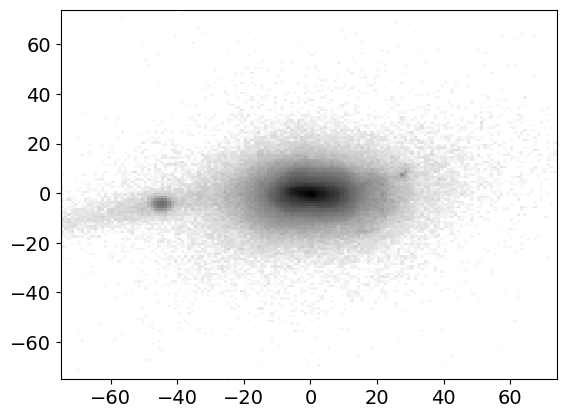

In [10]:
in_view = rdist_to_host < 100.

bins = np.arange(-75,75,1)
_=ek.hist2d(
    particle_data['star']['position'][in_view,0] - particle_data.host['position'][0,0],
    particle_data['star']['position'][in_view,2] - particle_data.host['position'][0,2],
    bins=bins,
    zscale='log'
)

In [14]:
image, _, _ = np.histogram2d ( 
    particle_data['star']['position'][in_view,0] - particle_data.host['position'][0,0],
    particle_data['star']['position'][in_view,2] - particle_data.host['position'][0,2],
    weights=particle_data['star']['mass'][in_view],
    bins=bins
)

(<matplotlib.image.AxesImage at 0x331c506d0>, <Axes: >)

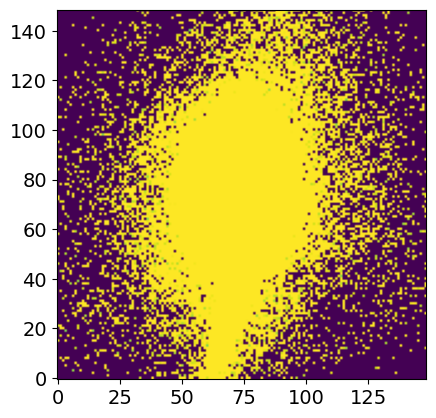

In [38]:
import pickle

In [251]:
prob_labels = np.load('../output/fire2_mock/problabels_recompute/probability_labels.npy')
with open('../output/fire2_mock/train_test_split.pkl','rb') as f:
    test_train = pickle.load(f)

with open('../output/fire2_mock/dimensionality_reduction_results.pkl','rb') as f:
    dimred = pickle.load(f)

with open('../output/fire2_mock/fire2_mock_data.pkl','rb') as f:
    mocks = pickle.load(f)

with open ('../output/fire2_mock/problabels_recompute/recomputed_pca.pkl', 'rb') as f:
    embeddings = pickle.load(f)

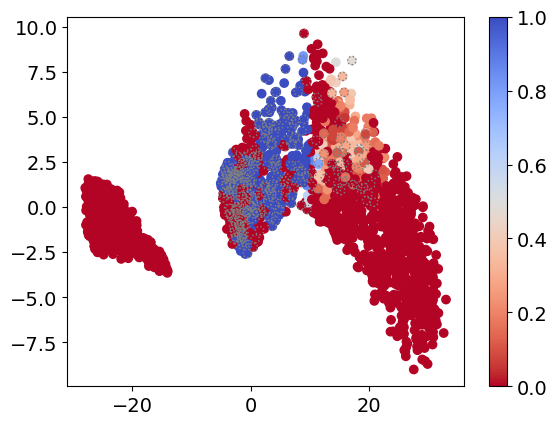

In [252]:
cidx = 1
xidx = 0
yidx = 1
plt.scatter(
    embeddings['embeddings_pca'][:,xidx],
    embeddings['embeddings_pca'][:,yidx],
    c=prob_labels[:,cidx],
    cmap='coolwarm_r',
    vmin=0.,
    vmax=1.
)
plt.colorbar()

mask = (test_train['train_mask'])&(dimred['true_labels']==cidx)
plt.scatter(
    embeddings['embeddings_pca'][mask,xidx],
    embeddings['embeddings_pca'][mask,yidx],
    ec='grey',
    fc='None',
    ls=':'
)


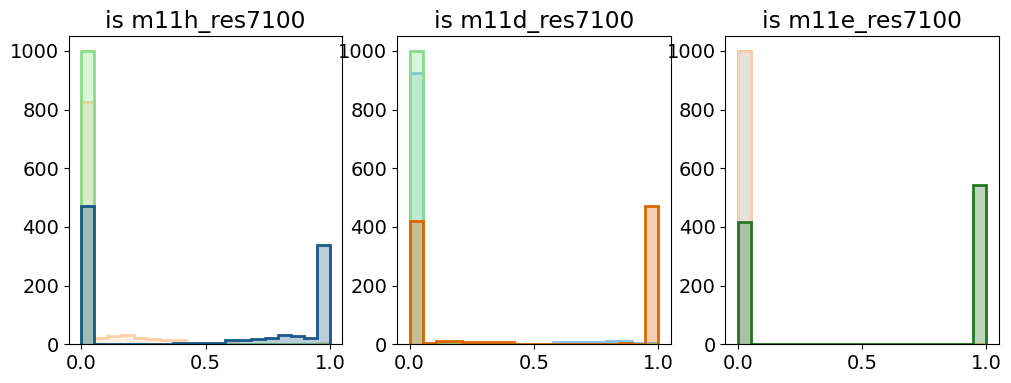

In [253]:
fig, axarr = plt.subplots(1,3,figsize=(12,4))
prbins = np.linspace(0.,1.,20)

hkwargs = {'alpha':0.3, 'lw':2, 'bins':prbins}
for cidx in range(3):
    ek.hist(prob_labels[dimred['true_labels']==cidx,0], label=mocks['class_names'][0], ax=axarr[cidx], 
            color=ec.ColorBase(f'C0').modulate(cidx==0 and -0.1 or 0.3).base, zorder=cidx==0 and 1 or 0, **hkwargs)
    ek.hist(prob_labels[dimred['true_labels']==cidx,1], label=mocks['class_names'][1], ax=axarr[cidx], 
            color=ec.ColorBase(f'C1').modulate(cidx==1 and -0.1 or 0.3).base, zorder=cidx==1 and 1 or 0, **hkwargs)
    ek.hist(prob_labels[dimred['true_labels']==cidx,2], label=mocks['class_names'][2], ax=axarr[cidx],
            color=ec.ColorBase(f'C2').modulate(cidx==2 and -0.1 or 0.3).base, zorder=cidx==2 and 1 or 0, **hkwargs)
    axarr[cidx].set_title(f'is {mocks["class_names"][cidx]}')
#plt.legend(title='Pr[class]')
#plt.xlabel('Pr[class]')


m11d_res7100


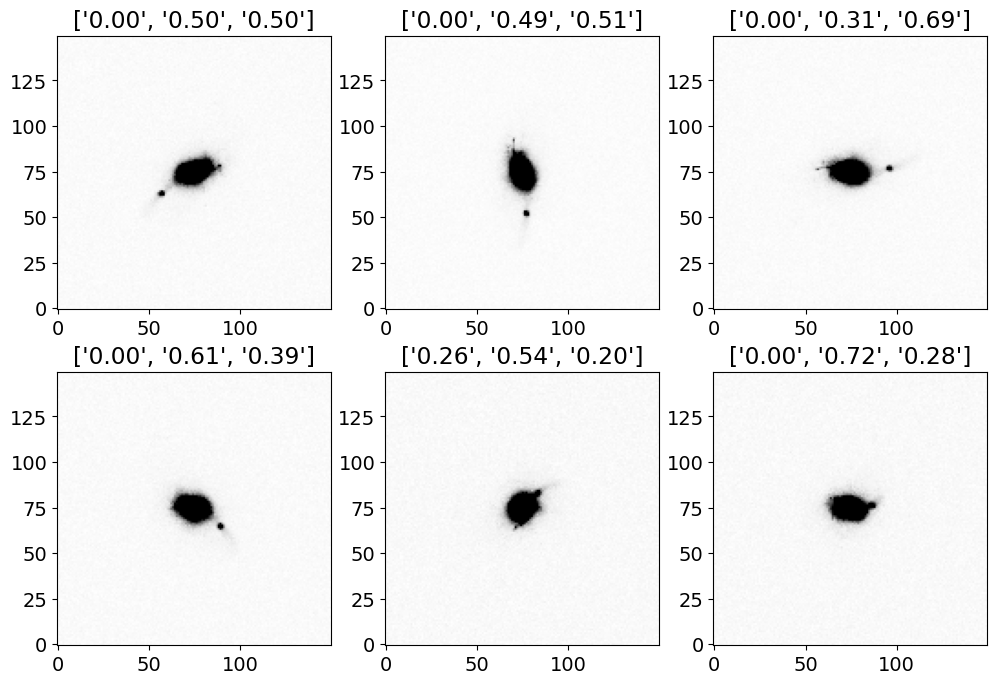

In [215]:
true_idx = 1
print(mocks['class_names'][true_idx])
misclassified = (dimred['true_labels']==true_idx)&(np.argmax(prob_labels, axis=1)!=true_idx)&(np.sum(prob_labels,axis=1)>0)
classified_correctly = (dimred['true_labels']==true_idx)&(np.argmax(prob_labels, axis=1)==true_idx)&(np.sum(prob_labels,axis=1)>0)


fig, axarr = plt.subplots(2,3,figsize=(12,8))
for idx in range(3):
    if idx >= misclassified.sum():
        continue
    axarr[0,idx].set_title([ f'{x:.2f}' for x in  prob_labels[misclassified][idx]])
    ek.imshow(mockdata['images'][misclassified][idx], ax=axarr[0,idx], q=0.01, cmap='Greys')

for idx in range(3):
    axarr[1,idx].set_title([ f'{x:.2f}' for x in  prob_labels[classified_correctly][idx]])
    ek.imshow(mockdata['images'][classified_correctly][idx], ax=axarr[1,idx], q=0.01, cmap='Greys')

In [55]:
ls ../output/fire2_mock/

byol_final_model.pt                   probabilistic_metrics.json
classification_metrics_hard.json      probability_analysis.png
dimensionality_reduction_results.pkl  probability_labels.npy
embeddings.npy                        qa_figure.png
evaluation_results.png                sample_fire2_galaxies.png
fire2_mock_data.pkl                   train_test_split.pkl
model_checkpoint.pt
